In [1]:
from IPython.display import Image, display

image_url = "https://assets-global.website-files.com/61bc763d72a0c6a0551afca9/63a22f056cc58752d5b55922_about-hptechventures.png"

# Display the image with a specified width
display(Image(url=image_url, width=200))  # Adjust the width as needed

> # Charlene Bui - HP Tech Ventures Externship Startups Analysis
Aiming to uncover patterns that could inform investment decisions for HP Tech Ventures.

## **Load Data**

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

file_path = "/kaggle/input/hptv-eda-dataset/Dataset.xlsx - 20150101 (1).csv"

data = pd.read_csv(file_path)
print("Data successfully loaded. Shape:", data.shape)

Data successfully loaded. Shape: (21164, 14)


In [3]:
# Display the first few rows and data info
print("\nFirst few rows of the dataset:")
print(data.head())


First few rows of the dataset:
  Organization Name     Headquarters Location  \
0             Nexar           Tel Aviv Israel   
1           Medable  California United States   
2          Instabox     Stockholms Lan Sweden   
3           Triller    New York United States   
4           OPSkins  California United States   

                                          Industries  \
0  Apps, Autonomous Vehicles, Internet, Sensor, T...   
1  Developer APIs, Health Care, Medical, Medical ...   
2       Logistics, Shipping, Supply Chain Management   
3               Digital Media, Music, Social Network   
4                       E-Commerce, Gaming, Internet   

          Last Funding Type  Last Funding Amount Currency (in USD)  \
0                  Series C                             52000000.0   
1  Venture - Series Unknown                             25000000.0   
2            Debt Financing                             24978252.0   
3                  Series B                             

In [4]:
print("\nDataset information:")
print(data.info())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21164 entries, 0 to 21163
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Organization Name                       21162 non-null  object 
 1   Headquarters Location                   19186 non-null  object 
 2   Industries                              20996 non-null  object 
 3   Last Funding Type                       12142 non-null  object 
 4   Last Funding Amount Currency (in USD)   9657 non-null   float64
 5   Number of Employees                     19625 non-null  object 
 6   Total Funding Amount Currency (in USD)  10730 non-null  float64
 7   Number of Funding Rounds                12142 non-null  float64
 8   Avg Amount of Each Round                21164 non-null  object 
 9   Number of Founders                      15785 non-null  float64
 10  Founded Date                        

## **Clean up Data**

> #### **1. Handle missing values**

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Define columns to impute
cols_to_impute = ['Last Funding Amount Currency (in USD)', 'Total Funding Amount Currency (in USD)', 
                  'Number of Funding Rounds', 'Number of Founders']

# Create an instance of the imputer
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)

# Fit the imputer and transform the data
imputed_data = pd.DataFrame(imputer.fit_transform(data[cols_to_impute]), columns=cols_to_impute)

# Replace the original columns with imputed values
data[cols_to_impute] = imputed_data

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
# For categorical columns, fill with 'N/A'
categorical_columns = ["Organization Name", "Headquarters Location", "Industries", "Last Funding Type", "Number of Employees", "Funding Status"]
data[categorical_columns] = data[categorical_columns].fillna("N/A")


> #### **2. Standardize data types**

In [7]:
# Convert 'Founded Date' to datetime with the correct format
data['Founded Date'] = pd.to_datetime(data['Founded Date'], format='%m/%d/%Y', errors='coerce')

# Convert 'Avg Amount of Each Round' to numeric
data['Avg Amount of Each Round'] = pd.to_numeric(data['Avg Amount of Each Round'].replace({'Unknown': np.nan}), errors='coerce')

> #### **3. Encoding for categorical data**

> > ##### **a. Label encoding**

In [14]:
# Create a copy of the DataFrame and remove columns to disregard
df = data.drop(['Organization Name', 'Industries', 'Founded Date'], axis=1).copy()

# Function for label encoding
def label_encode(df, column):
    le = LabelEncoder()
    df[f'{column}_encoded'] = le.fit_transform(df[column].astype(str))
    return df

# Columns for label encoding (ordinal data)
label_encode_columns = ['Number of Employees', 'Estimated Revenue Range']

# Apply label encoding
for column in label_encode_columns:
    df = label_encode(df, column)

> > ##### **b. One-hot encoding**

In [15]:
# Function to perform one-hot encoding
def one_hot_encode(df, column):
    one_hot = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df

# Columns for one-hot encoding (nominal data)
one_hot_columns = ['Last Funding Type', 'Funding Status', 'Headquarters Location']

# Apply one-hot encoding
df = pd.get_dummies(df, columns=one_hot_columns, prefix=one_hot_columns)
    
# Print info about one-hot encoded columns
for column in one_hot_encode_columns:
    print(f"\nOne-hot encoded columns for {column}:")
    print(df.filter(regex=f'^{column}_').columns.tolist())


One-hot encoded columns for Headquarters Location:
['Headquarters Location_Aargau Switzerland', 'Headquarters Location_Aberdeen City United Kingdom', 'Headquarters Location_Abruzzi Italy', 'Headquarters Location_Abu Dhabi United Arab Emirates', 'Headquarters Location_Acre Brazil', 'Headquarters Location_Ad Daqahliyah Egypt', 'Headquarters Location_Adis Abeba Ethiopia', 'Headquarters Location_Aichi Japan', 'Headquarters Location_Ajman United Arab Emirates', 'Headquarters Location_Akershus Norway', 'Headquarters Location_Al Jizah Egypt', 'Headquarters Location_Al Kuwayt Kuwait', 'Headquarters Location_Al Manamah Bahrain', 'Headquarters Location_Al Qahirah Egypt', 'Headquarters Location_Alabama United States', 'Headquarters Location_Alaska United States', 'Headquarters Location_Alberta Canada', 'Headquarters Location_Almaty City Kazakhstan', 'Headquarters Location_Alsace France', 'Headquarters Location_Amman Jordan', 'Headquarters Location_Andalucia Spain', 'Headquarters Location_Andhra 

## **Create correlation matrix heatmap**

In [22]:
# Select the relevant columns for our analysis
relevant_columns = [
    'Total Funding Amount Currency (in USD)',
    'Number of Funding Rounds',
    'Estimated Revenue Range_encoded',
    'Number of Employees_encoded',
    'Years since Founded',
    'Number of Founders',
    'Last Funding Amount Currency (in USD)']

# Calculate the correlation matrix for these columns
correlation_matrix = df[relevant_columns].corr()

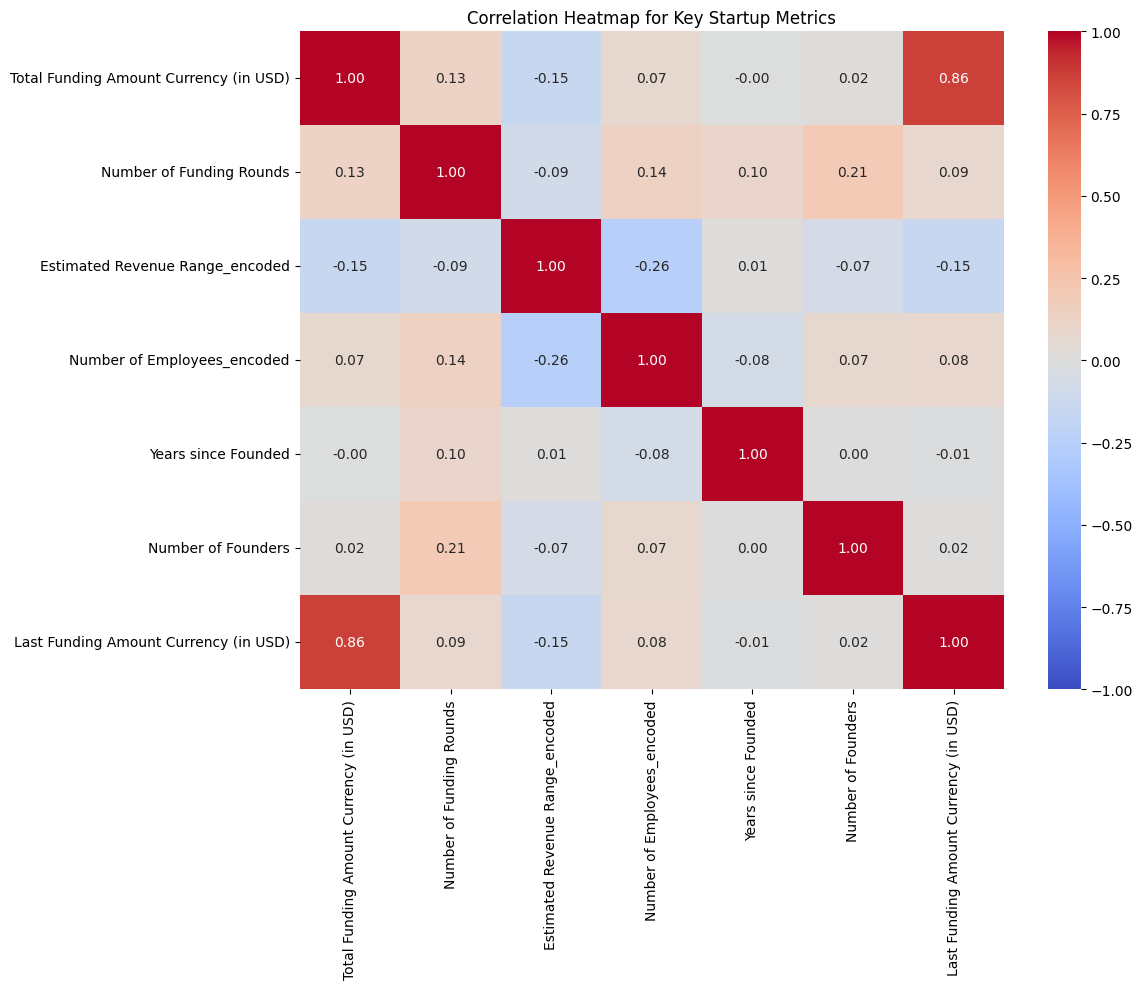

In [23]:
# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Correlation Heatmap for Key Startup Metrics')
plt.tight_layout()
plt.show()

In [19]:
# If you want to see the actual correlation values, you can print the matrix
print(correlation_matrix)

                                                    Last Funding Amount Currency (in USD)  \
Last Funding Amount Currency (in USD)                                            1.000000   
Total Funding Amount Currency (in USD)                                           0.863118   
Number of Funding Rounds                                                         0.085822   
Number of Founders                                                               0.015508   
Years since Founded                                                             -0.013559   
...                                                                                   ...   
Headquarters Location_Zhejiang China                                             0.013100   
Headquarters Location_Zilina Slovakia (Slovak R...                              -0.001286   
Headquarters Location_Zug Switzerland                                            0.004373   
Headquarters Location_Zuid-Holland The Netherlands                    

In [20]:
# Function to interpret correlation
def interpret_correlation(var1, var2, corr):
    print(f"\nCorrelation between {var1} and {var2}: {corr:.2f}")
    if abs(corr) < 0.3:
        print("Weak correlation")
    elif abs(corr) < 0.7:
        print("Moderate correlation")
    else:
        print("Strong correlation")
    print(f"This suggests that as {var1} {'increases' if corr > 0 else 'decreases'}, {var2} tends to {'increase' if corr > 0 else 'decrease'}.")

In [21]:
# Interpret key relationships
interpret_correlation('Total Funding Amount', 'Number of Funding Rounds', 
                      correlation_matrix.loc['Total Funding Amount Currency (in USD)', 'Number of Funding Rounds'])

interpret_correlation('Total Funding Amount', 'Estimated Revenue Range', 
                      correlation_matrix.loc['Total Funding Amount Currency (in USD)', 'Estimated Revenue Range_encoded'])

interpret_correlation('Total Funding Amount', 'Number of Employees', 
                      correlation_matrix.loc['Total Funding Amount Currency (in USD)', 'Number of Employees_encoded'])

interpret_correlation('Number of Employees', 'Estimated Revenue Range', 
                      correlation_matrix.loc['Number of Employees_encoded', 'Estimated Revenue Range_encoded'])

interpret_correlation('Years since Founded', 'Total Funding Amount', 
                      correlation_matrix.loc['Years since Founded', 'Total Funding Amount Currency (in USD)'])

interpret_correlation('Number of Founders', 'Total Funding Amount', 
                      correlation_matrix.loc['Number of Founders', 'Total Funding Amount Currency (in USD)'])

interpret_correlation('Last Funding Amount', 'Total Funding Amount', 
                      correlation_matrix.loc['Last Funding Amount Currency (in USD)', 'Total Funding Amount Currency (in USD)'])

interpret_correlation('Years since Founded', 'Estimated Revenue Range', 
                      correlation_matrix.loc['Years since Founded', 'Estimated Revenue Range_encoded'])

interpret_correlation('Number of Funding Rounds', 'Estimated Revenue Range', 
                      correlation_matrix.loc['Number of Funding Rounds', 'Estimated Revenue Range_encoded'])

interpret_correlation('Last Funding Amount', 'Number of Employees', 
                      correlation_matrix.loc['Last Funding Amount Currency (in USD)', 'Number of Employees_encoded'])


Correlation between Total Funding Amount and Number of Funding Rounds: 0.13
Weak correlation
This suggests that as Total Funding Amount increases, Number of Funding Rounds tends to increase.

Correlation between Total Funding Amount and Estimated Revenue Range: -0.15
Weak correlation
This suggests that as Total Funding Amount decreases, Estimated Revenue Range tends to decrease.

Correlation between Total Funding Amount and Number of Employees: 0.07
Weak correlation
This suggests that as Total Funding Amount increases, Number of Employees tends to increase.

Correlation between Number of Employees and Estimated Revenue Range: -0.26
Weak correlation
This suggests that as Number of Employees decreases, Estimated Revenue Range tends to decrease.

Correlation between Years since Founded and Total Funding Amount: -0.00
Weak correlation
This suggests that as Years since Founded decreases, Total Funding Amount tends to decrease.

Correlation between Number of Founders and Total Funding Amoun